In [29]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 36.50 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=8b33ed542f39989c149932e2e07c38ef707ab884989b8be7986ded9a9949e86b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qanxqaag/wheels/55/59/29/0fb1c63565215773

In [30]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


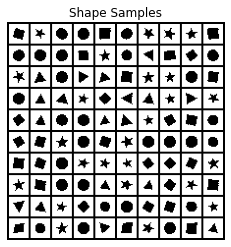

In [31]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [32]:
import os
import numpy as np
import copy
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as opt
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
    
    def forward(self, x):
        # self.weight.data *= mask
        return F.conv2d(x, self.mask * self.weight, bias=self.bias, stride=self.stride, padding=self.padding)

    def set_mask(self):
        raise NotImplementedError()


class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2] = 1
        self.mask[:, :, :h // 2] = 1
    

class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h // 2, : w // 2 + 1] = 1
        self.mask[:, :, :h // 2] = 1


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
      super().__init__()
      self.model = nn.Sequential(
          ConvB(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=1),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=7, padding=3),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels, kernel_size=1)
      )

    def forward(self, x):
        return self.model(x) + x


class PixelCNN(nn.Module):
    def __init__(self, input_shape, cf=120, k=5):
        super().__init__()
        self.h, self.w, self.n_channels = input_shape
        self.k = k
        self.bdist = Uniform(0., 1.)

        self.model = nn.Sequential(
            ConvA(self.n_channels, cf, 7, 1, 3),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            ResidualBlock(cf),
            nn.ReLU(),
            ConvB(cf, cf, 1), 
            nn.ReLU(), 
            ConvB(cf, k * 3, 1)
        )

    def forward(self, x):
        # return self.model(x)
        return self.model(x).reshape(
            x.shape[0], 
            self.k * 3, 
            1, 
            self.h, 
            self.w
        )

    def flow(self, x):
        mu, log_s, log_w = torch.chunk(self(x), 3, dim=1)
        w = F.softmax(log_w, dim=1)
        mix_dist = Normal(mu, log_s.exp())
        xr = x.repeat(1, self.k, 1, 1).unsqueeze(1)
        z = (mix_dist.cdf(xr) * w).sum(dim=1)
        log_det = (mix_dist.log_prob(xr).exp() * w).sum(dim=1).log()
        return z, log_det
    
    def loss(self, x):
        z, log_det = self.flow(x)
        z = torch.clip(z, 0, 1)
        return -(self.bdist.log_prob(z) + log_det).mean()

    def test(self, testloader):
        with torch.no_grad():
            loss = 0
            tc = 0
            for batch in tqdm(testloader):
                loss += self.loss(batch.to(device).float()) * batch.shape[0]
                tc += batch.shape[0]
            return loss / tc
                

    def fit(self, train_data, test_data, num_epochs=20, lr=1e-3, batch_size=128):

        trainloader = DataLoader(train_data.transpose(0, 3, 1, 2), batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_data.transpose(0, 3, 1, 2), batch_size=batch_size)

        train_loss = []
        test_loss = []

        optim = opt.Adam(self.parameters(), lr=lr)

        test_loss.append(self.test(testloader))

        for epoch in range(num_epochs):
            print("Epoch", epoch)

            for batch in tqdm(trainloader):
                loss = self.loss(batch.to(device).float())
                optim.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
                optim.step()

                train_loss.append(loss.cpu().data)

            test_loss.append(self.test(testloader))
        
        return train_loss, test_loss

    def sample(self):
        with torch.no_grad():
            sample = torch.zeros(1, 1, self.h, self.w).to(device)
            zs = self.bdist.sample((self.h, self.w)).to(device)
            for i in range(self.h):
                for j in range(self.w):
                    mu, log_s, log_w = torch.chunk(self(sample)[0, :, 0, i, j], 3)
                    w = F.softmax(log_w)
                    mix_dist = Normal(mu, log_s.exp())
                    sample[i, j] = bisect(
                        lambda x: (w * mix_dist.cdf(torch.tensor([x]*self.k))).sum() - zs[i, j],
                        -20, 20)
            return samples.cpu().detach().numpy().reshape(0, 2, 3, 1)

In [55]:
def q1(train_data, test_data):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    H = W = 20
    Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
        and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
    """
    
    """ YOUR CODE HERE """
    train_data = train_data[::18*5]
    test_data = test_data[::18*2]

    train_data = (train_data + np.random.uniform(size=train_data.shape)) / 2
    test_data = (test_data + np.random.uniform(size=test_data.shape)) / 2

    model = PixelCNN((20, 20, 1)).to(device)
    tr_loss, te_loss = model.fit(train_data, test_data, num_epochs=1)

    samples = np.vstack([model.sample() for _ in range(100)])

    return tr_loss, te_loss, samples



### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



In [56]:
q1_save_results(q1)

100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch 0


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: ignored